## Below Script Takes a Image as an output , Finds a Countours based on Edge detection and also outputs the Dominant color in the Bounding Box, although it can also output all the available colors based on the input given in the GetColors Function

In [9]:
#REquired Libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
from collections import Counter

In [10]:
# Helpper Function to read and get colors in images
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

# Image Path utility function
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Function to get prominent colors from image
def get_colors(image, number_of_colors, show_chart):
    
    # Modifies image to usable format  
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

    # Clusters color regions  
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)    
    center_colors = clf.cluster_centers_

    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    #colors = [x for x ==]
    # if (show_chart):
    #     plt.figure(figsize = (8, 6))
    #     plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

In [11]:
#Reading csv file with pandas and giving names to each column
index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv('/content/color_limit.csv', names=index, header=None)

In [12]:
#Helper function to get color Name From RGB Values
def getColorName(x):
    x  =list(x)
    R = x[0]
    G = x[1]
    B = x[2]
    minimum = 100
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

In [13]:
#Function to Detect Bounding Box and return Color with Boundary Co Ordinates

import cv2
from google.colab.patches import cv2_imshow
import imutils
from imutils import build_montages
from imutils.contours import sort_contours

def detect_roi_and_color(imagepath):
  img = cv2.imread(imagepath) 
  # Display original image
  cv2_imshow(img)
  #cv2.waitKey(0)
  # Convert to graycsale
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Blur the image for better edge detection
  img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
  # Sobel Edge Detection
  sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
  sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
  sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
  edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
  # Display Canny Edge Detection Image
  cv2_imshow(edges)
  #cv2.waitKey(0)
  contours=cv2.findContours(edges.copy(),cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  cnts = sort_contours(contours, method="left-to-right")[0]
  idx =0
  roi_list =[]
  color_found = []
  for cnt in cnts:
    idx += 1
    x,y,w,h = cv2.boundingRect(cnt)
    roi=img[y:y+h,x:x+w]
    roi_list.append([x,y,w,h])
    colors = getColorName(get_colors(roi, 1, True)[0]) #Detect first dominant color
    color_found.append(colors)
  return roi_list, color_found

In [15]:
imagepath = ['/content/ctwJ5.png','/content/51342054638.jpg','/content/test 1.jpeg']

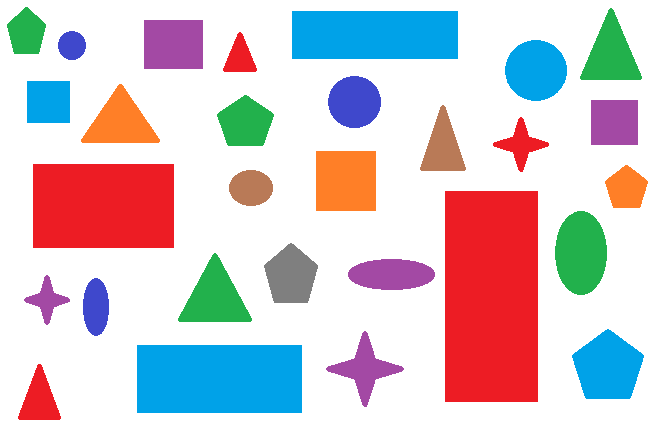

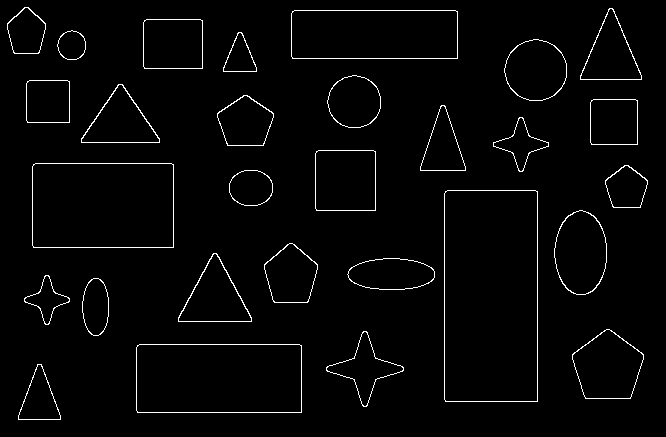

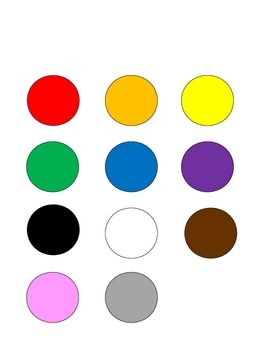

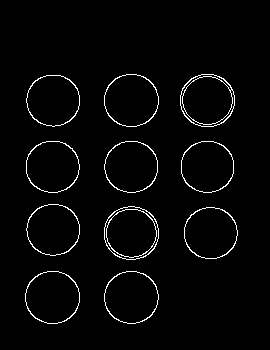

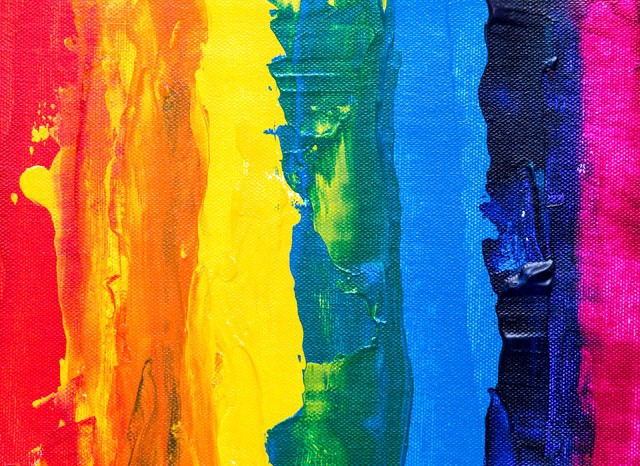

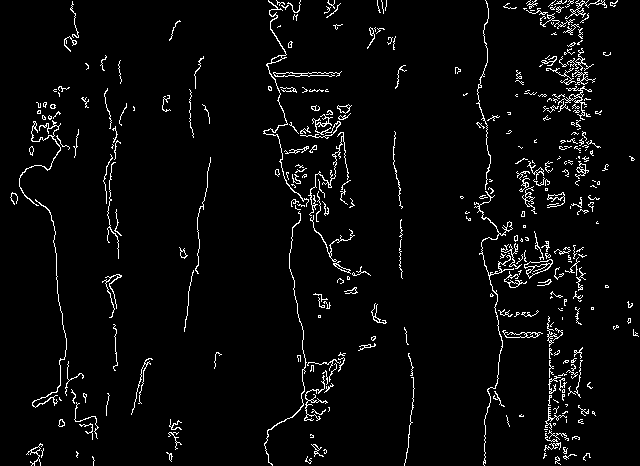

In [17]:
roi_list, color_found = [], []
for x in imagepath:
  c,v = [],[]
  c,v = detect_roi_and_color(x)
  roi_list.extend(c)
  color_found.extend(v)

In [18]:
df = None
df = pd.DataFrame(list(zip(roi_list, color_found)),
               columns =['BBox Coordinate', 'Dominant Color'])

In [20]:
df

,BBox Coordinate,Dominant Color
0,"[7, 7, 39, 47]",Mantis
1,"[7, 7, 39, 47]",Mantis
2,"[18, 364, 43, 56]",Medium Slate Blue
3,"[18, 364, 43, 56]",Medium Slate Blue
4,"[24, 275, 46, 50]",Thistle
...,...,...
612,"[627, 318, 4, 5]",Medium Orchid
613,"[627, 301, 6, 7]",Veronica
614,"[629, 156, 6, 5]",Veronica
615,"[631, 158, 4, 3]",Veronica


In [21]:
df.to_csv('ColorDetection.csv',index= False)